In [44]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [45]:
datapath = r"/Volumes/slab/_Data/170221 - EonHe M018V4/data/170223-094526_helium_curve.h5/00000_helium_curve.h5"
datapath_2 = r"/Volumes/slab/_Data/170221 - EonHe M018V4/data/170223-131956_helium_curve.h5/00000_helium_curve.h5"
datapath_3 = r"/Volumes/slab/_Data/170221 - EonHe M018V4/data/170223-141529_helium_curve.h5/00000_helium_curve.h5"

temperature = list()

with h5py.File(datapath, "r") as f:
    temperature = f["temperature"][()]
    fpoints = f["fpts"][()]
    mags = f["mags"][()]
    puffs = f["puff"][()]
print("Loaded File #1")
    
with h5py.File(datapath_2, "r") as f:
    temperature = np.hstack((temperature, f["temperature"][()][1:]))
    fpoints = f["fpts"][()]
    mags = np.vstack((mags, f["mags"][()][1:]))
    puffs = np.hstack((puffs, f["puff"][()][1:]))
print("Loaded File #2")

with h5py.File(datapath_3, "r") as f:
    temperature = np.hstack((temperature, f["temperature"][()][1:]))
    fpoints = f["fpts"][()]
    mags = np.vstack((mags, f["mags"][()][1:]))
    puffs = np.hstack((puffs, f["puff"][()][1:]))
print("Loaded File #3")

Loaded File #1
Loaded File #2
Loaded File #3


100%|██████████| 1929/1929 [00:23<00:00, 82.50it/s]


(5287900000.0, 5322900000.0)

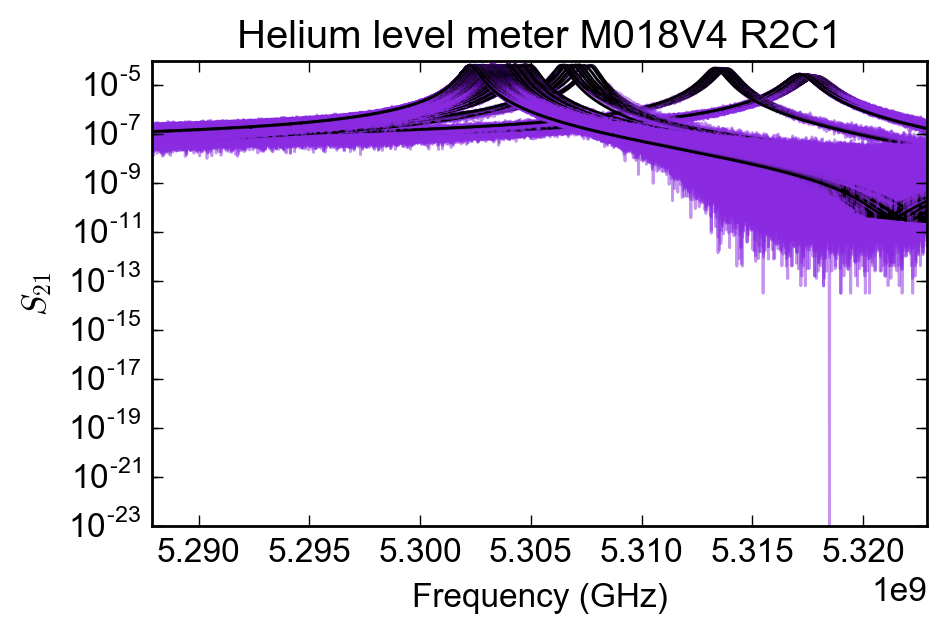

In [46]:
Qs = list()
f0s = list()

use_asymmetric_fit = True

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)

for idx in tqdm(range(np.shape(mags)[0])):
    xdata = np.array(fpoints, dtype=np.float64)
    ydata = common.dBm_to_W(np.array(mags[idx,:], dtype=np.float64))
    plt.plot(xdata, ydata, color='blueviolet', alpha=0.5)
    plt.yscale('log')

    if use_asymmetric_fit:
        fitguess = [np.max(ydata), fpoints[np.argmax(mags[idx,:])], 1E6/2., 0.05]
        fr, ferr = kfit.fit_lor_asym(xdata, ydata, fitparams=fitguess, 
                                     parambounds=[(-np.inf, -np.inf, 0, -np.inf),(+np.inf, +np.inf, +np.inf, +np.inf)], 
                                     verbose=False)
        plt.plot(xdata, kfit.asym_lorfunc(xdata, *fr), '-k')
        f0s.append(fr[-3])
        Qs.append(fr[-3]/(fr[-2]))
    else:
        fitguess = [1E-5, fpoints[np.argmax(mags[idx,:])], 1E6/2.]
        fr, ferr = kfit.fit_lor(xdata, ydata, fitparams=fitguess, no_offset=True, 
                                parambounds=[(-np.inf, -np.inf, 0),(+np.inf, +np.inf, +np.inf)], 
                                verbose=False)
        plt.plot(xdata, kfit.lorfunc(xdata, *fr), '-k')
        f0s.append(fr[-2])
        Qs.append(fr[-2]/(2*fr[-1]))
    
    
    #plt.xlim(np.min(fpoints/1E9), np.max(fpoints/1e9))
    #plt.ylim(1E-11, 2E-8)
    

    #print("QL = %d"%(fr[-3]/(2*fr[-2])))

    
f0s = np.array(f0s)
Qs = np.array(Qs)

plt.ylabel("$S_{21}$")
plt.xlabel("Frequency (GHz)")
plt.title("Helium level meter M018V4 R2C1")
plt.xlim(np.min(xdata), np.max(xdata))

Maximum frequency shift is  -15.67 MHz


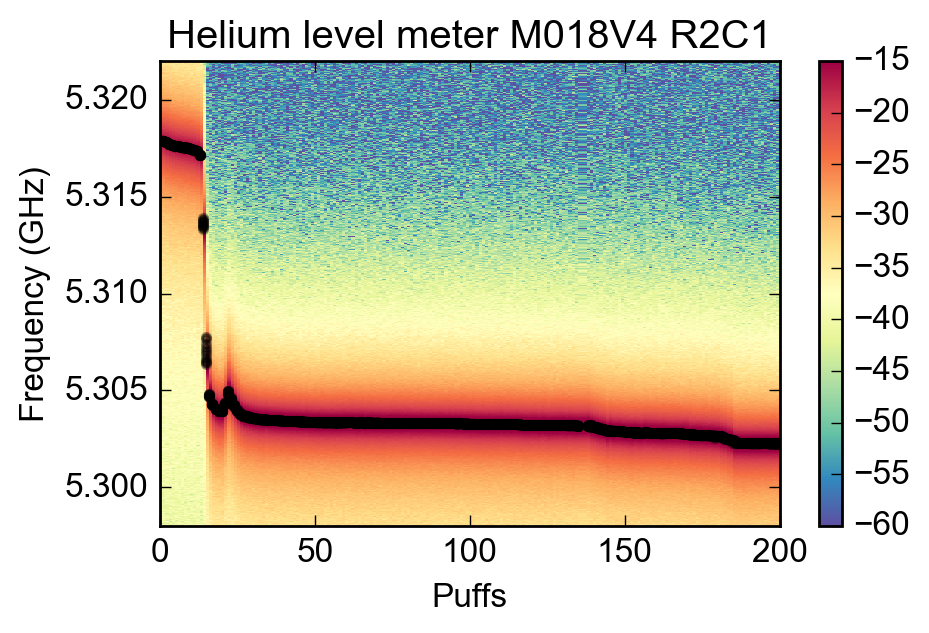

In [56]:
save=False

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.pcolormesh(puffs, fpoints/1E9, mags.T, cmap=plt.cm.Spectral_r, vmin=-60, vmax=-15)
plt.plot(puffs[:-1], f0s/1E9, 'o', **common.plot_opt('black', msize=3))
plt.colorbar()
plt.ylabel("Frequency (GHz)")
plt.xlim(np.min(puffs), np.max(puffs))
plt.ylim(np.min(fpoints/1E9), np.max(fpoints/1e9))
plt.title("Helium level meter M018V4 R2C1")
plt.xlabel("Puffs")
plt.ylim(5.298, 5.322)

if save: 
    common.save_figure(fig, save_path=os.path.split(datapath)[0])
    
print("Maximum frequency shift is  %.2f MHz"%((f0s[-1]-f0s[0])/1E6))

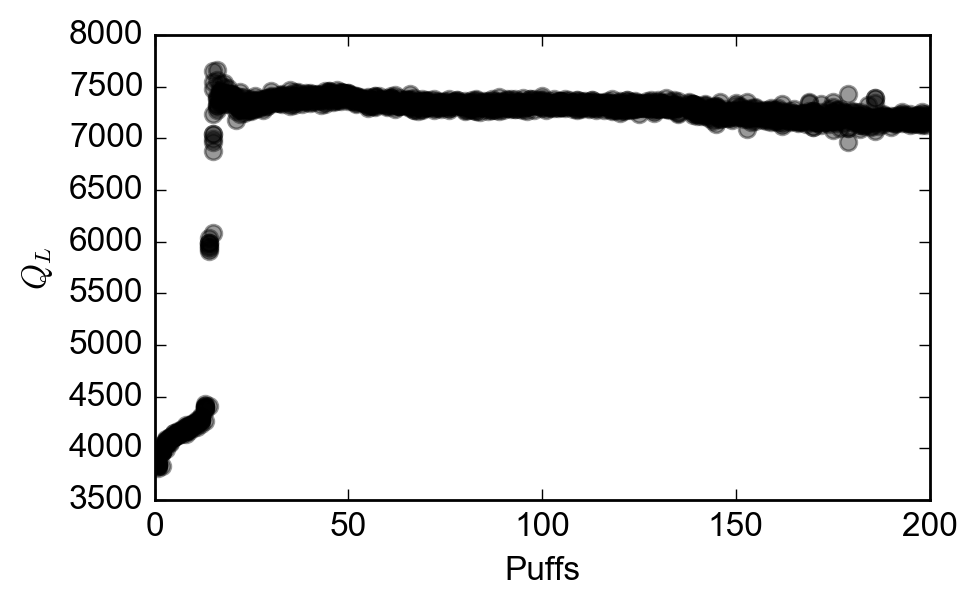

In [54]:
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(puffs[1:], Qs, 'o', **common.plot_opt('black', msize=6))
plt.xlabel("Puffs")
plt.ylabel("$Q_L$")

if save: 
    common.save_figure(fig, save_path=os.path.split(datapath)[0])
    